In [1]:
import os
from pathlib import Path
import xarray as xr
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt

This notebook takes the raw/downloaded information and pre-process it into a format suitable for AI/ML approaches. This pre-processing procedure assumes all gridded data is in the same spatio-temporal resolution.

# Outcome variable (or predictand)

## Above Ground Biomass

In [2]:
"""Load AGB data into an xarray dataset"""
agb_data = xr.open_dataset("/data1/raw_data/veg_2010_2016/all_veg_data.nc")
agb_data

<xarray.Dataset>
Dimensions:                (latitude: 720, longitude: 1440, time: 84)
Coordinates:
  * time                   (time) datetime64[ns] 2010-01-01 ... 2016-12-01
  * longitude              (longitude) float32 -179.9 -179.6 ... 179.6 179.9
  * latitude               (latitude) float32 -89.88 -89.62 ... 89.62 89.88
Data variables:
    abg_avitabile_vod5th   (time, latitude, longitude) float64 ...
    abg_avitabile_vodmean  (time, latitude, longitude) float64 ...
    abg_avitabile_vod95th  (time, latitude, longitude) float64 ...
    abg_baccini_vod5th     (time, latitude, longitude) float64 ...
    abg_baccini_vodmean    (time, latitude, longitude) float64 ...
    abg_baccini_vod95th    (time, latitude, longitude) float64 ...
    abg_saatchi_vod5th     (time, latitude, longitude) float64 ...
    abg_saatchi_vodmean    (time, latitude, longitude) float64 ...
    abg_saatchi_vod95th    (time, latitude, longitude) float64 ...

Now select below which data variable you would like to use as outcome, this will be used to mask all the other features.

In [3]:
# We suggest to select one of the maps by Avitabile et al.
# This is the outcome variable and also works as mask for all the features.
# All the features geerated from here onwards, will depend on this choice!
vartype = "mean"  # it can also be '05th' or '95th'
varname = "abg_avitabile_vod" + vartype

agb_data = eval("agb_data." + varname)
# Units
agb_data.units

'Mg/h'

In [4]:
agb_data

<xarray.DataArray 'abg_avitabile_vodmean' (time: 84, latitude: 720, longitude: 1440)>
[87091200 values with dtype=float64]
Coordinates:
  * time       (time) datetime64[ns] 2010-01-01 2010-02-01 ... 2016-12-01
  * longitude  (longitude) float32 -179.9 -179.6 -179.4 ... 179.4 179.6 179.9
  * latitude   (latitude) float32 -89.88 -89.62 -89.38 ... 89.38 89.62 89.88
Attributes:
    long_name:  AGB estimation using a relation Avitabile et al. as a fct of ...
    units:      Mg/h

Please note the units of AGB are Mg/h!

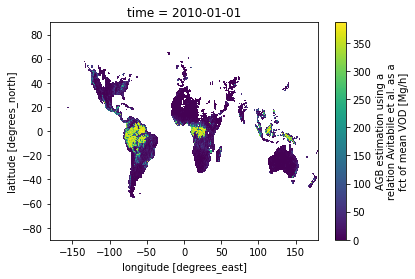

In [5]:
agb_data[0].plot()

In [6]:
# One of the predictors (VOD) is available from April 2010 to December 2016.
# Therefore here we remove Jan-Feb-Mar 2016.
agb_data = agb_data.loc["2010-04-01":"2016-12-31"]

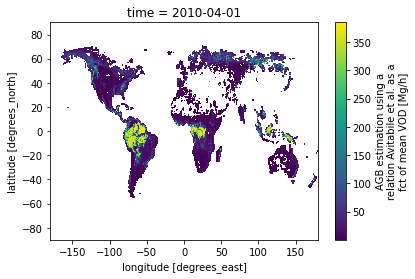

In [7]:
# Mask out where AGB is zero
AGB_THRESH = 0

agb_data = agb_data.where(agb_data != AGB_THRESH)
agb_data[0].plot()

## Burned Area

In [8]:
"""Load BA data into an xarray dataset"""
ba_data = xr.open_mfdataset(
    "/data1/raw_data/burned_area_2010_2018/201[0-6]*-ESACCI-L4_FIRE-BA-MODIS-fv5.1.nc"
)
# Units
ba_data.burned_area.units

'm2'

Please note the units of BA are m2!

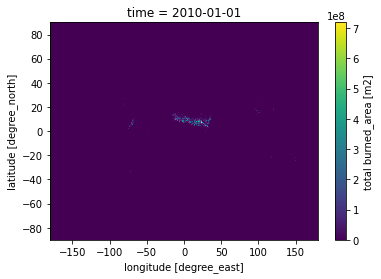

In [9]:
# Rename lat/lon dimensions
ba_data = ba_data.rename({"lon": "longitude", "lat": "latitude"})
# Extract only burned areas
ba_data = ba_data.burned_area

ba_data[0].plot()

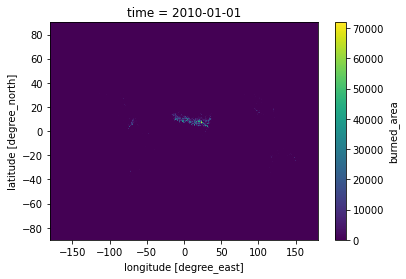

In [10]:
# Convert m2 to hectares
ba_data_h = ba_data * 0.0001
ba_data_h[0].plot()

In [11]:
# One of the predictors (VOD) is available from April 2010 to December 2016.
# Therefore here we remove Jan-Feb-Mar 2016.
ba_data_h = ba_data_h.loc["2010-04-01":"2016-12-31"]

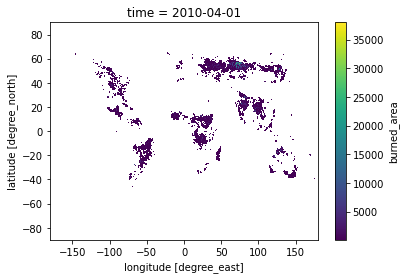

In [12]:
# Mask out low values (small fires)
BA_THRESH = 50  # hectares
ba_data_h = ba_data_h.where(ba_data_h > BA_THRESH)

ba_data_h[0].plot()

## Load

The load (Mg) is the Above Ground Biomass (Mg/h) * Burned Area (h). This operation is straightforward because the grids have the same spatial and temporal resolution! Please note the result shows values where both BA and AGB are not equal to NA. 

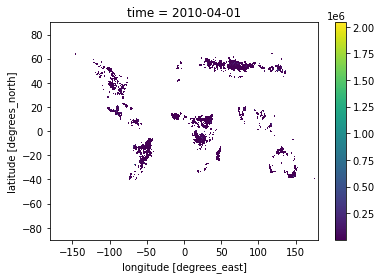

In [13]:
load_data = agb_data * ba_data_h
load_data[0].plot()

In [17]:
# Store data, if needed.
folder_path = "/home/moc0/ai-vegetation-fuel/data/inputs/nc_files_" + vartype + "/"
Path(folder_path).mkdir(parents=True, exist_ok=True)
load_data.to_netcdf(folder_path + "load_2010-2016.nc")

# Static predictors

## Climatic regions

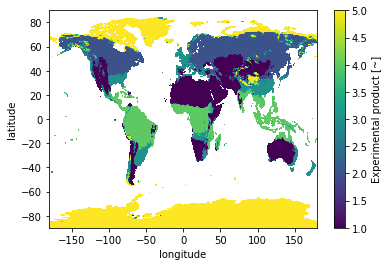

In [18]:
"""Load climatic regions data into an xarray dataset"""
cr_data = xr.open_dataset("/data1/raw_data/Beck_KG_V1_present_0p0083.gridName0320.nc")
# Rotate longitude coordinates
cr_data = cr_data.assign_coords(
    longitude=(((cr_data.longitude + 180) % 360) - 180)
).sortby("longitude")
# Interpolate to match AGB resolution
climate_region = cr_data.climatic_region.interp(
    coords={
        "latitude": agb_data.latitude.values,
        "longitude": agb_data.longitude.values,
    },
    method="nearest",
)  # Wikilimo used default method ('linear')
climate_region.plot()

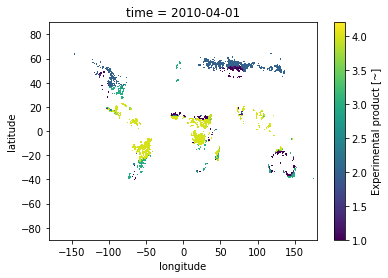

In [19]:
# Replicate the same layer 81 times to match load's temporal resolution
cr_data = [climate_region for i in range(0, 81)]
cr_data = xr.concat(cr_data, "time")
cr_data["time"] = load_data["time"]
# Mask using the load
cr_data = cr_data.where(load_data >= 0)
cr_data[0].plot()

# Store data, if needed.
cr_data.to_netcdf(folder_path + "climatic_region_2010-2016.nc")

## Slope

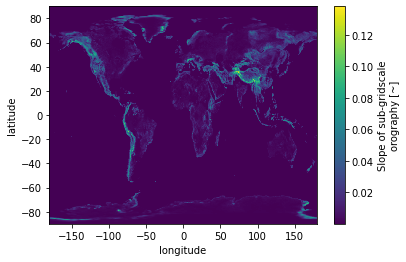

In [20]:
"""Load slope data into an xarray dataset"""
slope_data = xr.open_mfdataset("/data1/raw_data/slope_O320.nc")
# Rotate longitude coordinates
slope_data = slope_data.slor.assign_coords(
    longitude=(((slope_data.longitude + 180) % 360) - 180)
).sortby("longitude")
# Interpolate to match AGB resolution
slope_data = slope_data.interp(
    coords={
        "latitude": agb_data.latitude.values,
        "longitude": agb_data.longitude.values,
    },
    method="linear",
)  # Wikilimo used default method ('linear')
slope_data.plot()

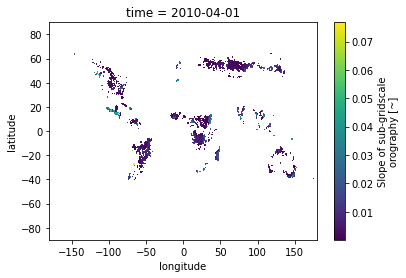

In [21]:
# Replicate the same layer 81 times to match load's temporal resolution
sl_data = [slope_data for i in range(0, 81)]
sl_data = xr.concat(sl_data, "time")
sl_data["time"] = load_data["time"]
# Mask using the load
sl_data = sl_data.where(load_data >= 0)
sl_data[0].plot()

# Store data, if needed.
sl_data.to_netcdf(folder_path + "slope_2010-2016.nc")

## Biomes

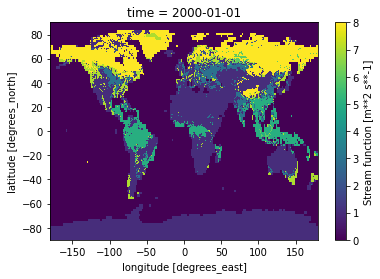

In [58]:
"""Load slope data into an xarray dataset"""
biomes = xr.open_dataset("/data1/downloaded/landcover_25.nc")
# Convert to data array and select the only time step available
biomes = biomes.STRF[0]
biomes.plot()

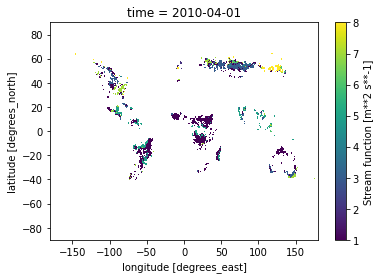

In [59]:
# Replicate the same layer 81 times to match load's temporal resolution
biomes_data = [biomes for i in range(0, 81)]
biomes_data = xr.concat(biomes_data, "time")
biomes_data["time"] = load_data["time"]
# Mask using the load
biomes_data = biomes_data.where(load_data >= 0)
biomes_data[0].plot()

# Store data, if needed.
biomes_data.to_netcdf(folder_path + "biomes_2010-2016.nc")

# Dynamic predictors

## Leaf Area Index

Remote sensing LAI methods generate a map of dimensionless LAI values assigned to each pixel. Values can range from 0 (bare ground) to 6 or more, but since rangeland vegetation is generally sparse, values commonly range from 0-1. A LAI value of 1 means that there is the equivalent of 1 layer of leaves that entirely cover a unit of ground surface area, and less than one means that there is some bare ground between vegetated patches. LAI values over 1 indicate a layered canopy with multiple layers of leaves per unit ground surface area. LAI and fPAR data are commonly packaged together (e.g., MODIS products).

/home/moc0/miniconda3/envs/ml-fuel/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


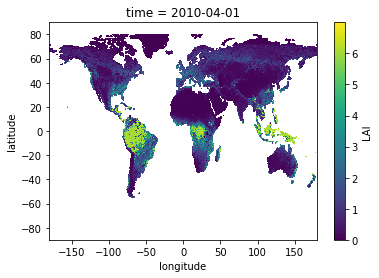

In [24]:
"""Load LAI data into an xarray dataset"""
lai_data = xr.open_mfdataset(
    "/data1/raw_data/LAI_interpolated_2010_2017/LAI_201[0-6]*.nc"
)
# Rename lat/lon dimensions
lai_data = lai_data.LAI.rename({"lon": "longitude", "lat": "latitude"})
# Calculate monthly means
lai_data = lai_data.resample(time="1MS").mean(dim="time")
# Interpolate to match AGB resolution
lai_data = lai_data.interp(
    coords={
        "latitude": agb_data.latitude.values,
        "longitude": agb_data.longitude.values,
    },
    method="linear",
)  # Wikilimo used default method ('linear')
# One of the predictors (VOD) is available from April 2010 to December 2016.
# Therefore here we remove Jan-Feb-Mar 2016.
lai_data = lai_data.loc["2010-04-01":"2016-12-31"]
lai_data[0].plot()

/home/moc0/miniconda3/envs/ml-fuel/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/moc0/miniconda3/envs/ml-fuel/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


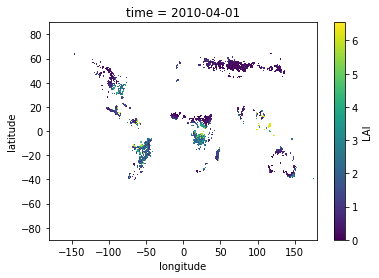

In [25]:
# Mask using the load
lai_data = lai_data.where(load_data >= 0)
lai_data[0].plot()

# Store data, if needed.
lai_data.to_netcdf(folder_path + "lai_2010-2016.nc")

## Vegetation Optical Depth (VDO)

/home/moc0/miniconda3/envs/ml-fuel/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


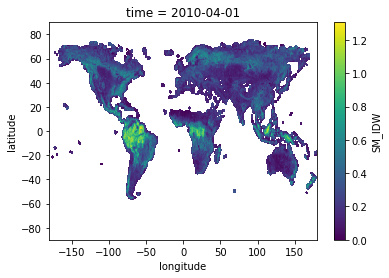

In [30]:
"""Load VOD data into an xarray dataset"""
vodfiles = [
    os.path.join(d, x)
    for year in range(2010, 2017)
    for d, dirs, files in os.walk("/data1/downloaded/ESA_VOD/" + str(year))
    for x in files
    if x.endswith(".nc")
]
vod_data = xr.open_mfdataset(vodfiles)
# Select variable of interest: SM_IDW
vod_data = vod_data.SM_IDW
# Calculate monthly means
vod_data = vod_data.resample(time="1MS").mean(dim="time")
# Interpolate to match load's resolution
vod_data = vod_data.interp(
    coords={
        "latitude": load_data.latitude.values,
        "longitude": load_data.longitude.values,
    },
    method="linear",
)

vod_data[0].plot()

/home/moc0/miniconda3/envs/ml-fuel/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/moc0/miniconda3/envs/ml-fuel/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


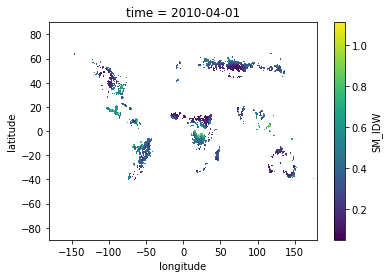

In [31]:
# Mask using the load
vod_data = vod_data.where(load_data >= 0)
vod_data[0].plot()

# Store data, if needed.
vod_data.to_netcdf(folder_path + "vod_2010_2016.nc")

## Standardised Precipitation Index

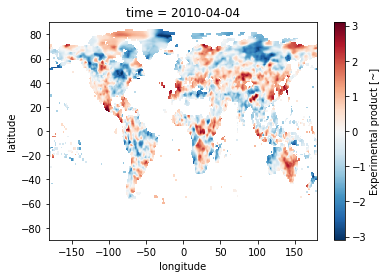

In [39]:
"""Load SPI data into an xarray dataset"""
spi_data = xr.open_mfdataset("/data1/raw_data/SPI_GPCC/output_201[0-6]*.nc")
# Rotate longitude coordinates
spi_data = spi_data.assign_coords(
    longitude=(((spi_data.longitude + 180) % 360) - 180)
).sortby("longitude")
# Interpolate to match load resolution
spi_data = spi_data.interp(
    coords={
        "latitude": load_data.latitude.values,
        "longitude": load_data.longitude.values,
    },
    method="linear",
)  # Wikilimo used default method ('linear')
# One of the predictors (VOD) is available from April 2010 to December 2016.
# Therefore here we remove Jan-Feb-Mar 2016.
spi_data = spi_data.loc[dict(time=slice("2010-04-01", "2016-12-31"))]
spi_data.spi03[0].plot()

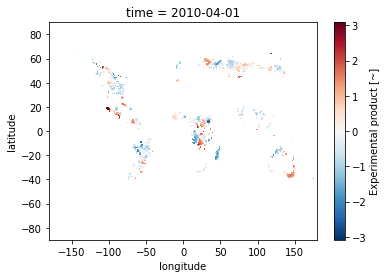

In [40]:
# Fix time stamps
spi_data["time"] = load_data["time"]
# Mask using the load
spi_data = spi_data.where(load_data >= 0)
spi_data.spi03[0].plot()

# Store data, if needed.
spi_data.to_netcdf(folder_path + "spi_2010_2016.nc")

## Weather Anomalies

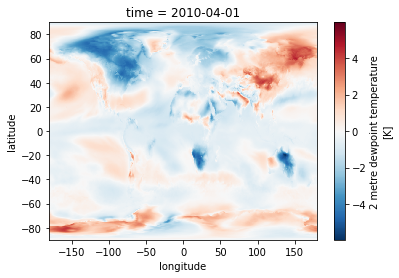

In [42]:
"""Load Weather data into an xarray dataset"""
wa_data = xr.open_mfdataset("/data1/raw_data/SEAS5_anomalies/S5_anomaly_201[0-6]*.nc")
# Rotate longitude coordinates
wa_data = wa_data.assign_coords(
    longitude=(((wa_data.longitude + 180) % 360) - 180)
).sortby("longitude")
# Interpolate to match load resolution
wa_data = wa_data.interp(
    coords={
        "latitude": load_data.latitude.values,
        "longitude": load_data.longitude.values,
    },
    method="linear",
)  # Wikilimo used default method ('linear')
# One of the predictors (VOD) is available from April 2010 to December 2016.
# Therefore here we remove Jan-Feb-Mar 2016.
wa_data = wa_data.loc[dict(time=slice("2010-04-01", "2016-12-31"))]
wa_data.d2m[0].plot()

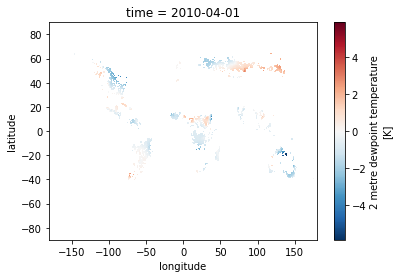

In [43]:
# Mask using the load
wa_data = wa_data.where(load_data >= 0)
wa_data.d2m[0].plot()

# Store data, if needed.
wa_data.to_netcdf(folder_path + "weather_anomalies_2010_2016.nc")

## Fire anomalies (to be recalculated on Monday 23rd April 2021!)

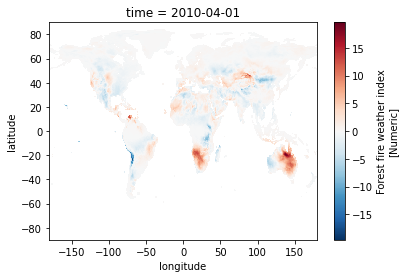

In [49]:
"""Load fire data into an xarray dataset"""
fa_data = xr.open_mfdataset(
    "/data1/raw_data/SEAS_FIRE_ANOMALIES_2010_2018/ECMWF_FWI_201[0-6]*_anom_m1.nc"
)
# Rotate longitude coordinates
fa_data = fa_data.assign_coords(
    longitude=(((fa_data.longitude + 180) % 360) - 180)
).sortby("longitude")
# Interpolate to match load resolution
fa_data = fa_data.interp(
    coords={
        "latitude": load_data.latitude.values,
        "longitude": load_data.longitude.values,
    },
    method="linear",
)  # Wikilimo used default method ('linear')
# One of the predictors (VOD) is available from April 2010 to December 2016.
# Therefore here we remove Jan-Feb-Mar 2016.
fa_data = fa_data.loc[dict(time=slice("2010-04-01", "2016-12-31"))]
fa_data.fwinx[0].plot()

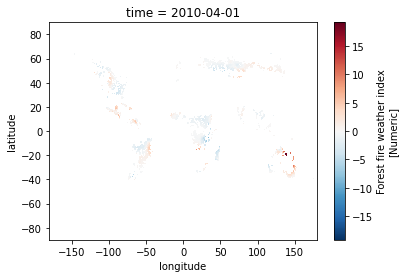

In [50]:
# Mask using load
fa_data = fa_data.where(load_data >= 0)
fa_data.fwinx[0].plot()

# Store data, if needed.
fa_data.to_netcdf(folder_path + "fire_anomalies_2010-2016.nc")

# Convert gridded information to table

In [ ]:
frames = [
    load_data.to_dataframe(name="fuel_load").dropna(),  # outcome (unnamed) feature
    cr_data.to_dataframe(name="climatic_region").dropna(),  # static (unnamed) feature
    sl_data.to_dataframe(name="slope").dropna(),  # static (unnamed) feature
    biomes_data.to_dataframe(name="biome").dropna(),  # static (unnamed) feature
    lai_data.to_dataframe(name="lai").dropna(),  # dynamic (unnamed) feature
    vod_data.to_dataframe(name="vod").dropna(),  # dynamic (unnamed) feature
    spi_data.to_dataframe().dropna(),  # dynamic (named) features
    wa_data.to_dataframe().dropna(),  # dynamic (named) features
    fa_data.to_dataframe().dropna(),
]  # dynamic (named) features

# Perform an inner join to get rows without NAs
df = pd.concat(frames, join="inner")

In [ ]:
df.to_csv("model_input_dataframe.csv")